In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

from sklearn.utils import shuffle
from datetime import datetime

In [4]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [14]:
class Tree:
    def __init__(self, word, label):
        self.left = None
        self.right = None
        self.word = word
        self.label = label


def display_tree(t, lvl=0):
    prefix = ''.join(['>']*lvl)
    if t.word is not None:
        print("%s%s %s" % (prefix, t.label, t.word))
    else:
        print("%s%s -" % (prefix, t.label))
        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
    if t.left:
        display_tree(t.left, lvl + 1)
    if t.right:
        display_tree(t.right, lvl + 1)


current_idx = 0
def str2tree(s, word2idx):
    # take a string that starts with ( and MAYBE ends with )
    # return the tree that it represents
    # EXAMPLE: "(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))"
    # NOTE: not every node has 2 children (possibly not correct ??)
    # NOTE: not every node has a word
    # NOTE: every node has a label
    # NOTE: labels are 0,1,2,3,4
    # NOTE: only leaf nodes have words
    # s[0] = (, s[1] = label, s[2] = space, s[3] = character or (

    # print "Input string:", s, "len:", len(s)

    global current_idx

    label = int(s[1])
    if s[3] == '(':
        t = Tree(None, label)
        # try:

        # find the string that represents left child
        # it can include trailing characters we don't need, because we'll only look up to )
        child_s = s[3:]
        t.left = str2tree(child_s, word2idx)

        # find the string that represents right child
        # can contain multiple ((( )))
        # left child is completely represented when we've closed as many as we've opened
        # we stop at 1 because the first opening paren represents the current node, not children nodes
        i = 0
        depth = 0
        for c in s:
            i += 1
            if c == '(':
                depth += 1
            elif c == ')':
                depth -= 1
                if depth == 1:
                    break
        # print "index of right child", i

        t.right = str2tree(s[i+1:], word2idx)

        # except Exception as e:
        #     print "Exception:", e
        #     print "Input string:", s
        #     raise e

        # if t.left is None or t.right is None:
        #     raise Exception("Tree node has no word but left and right child are None")
        return t
    else:
        # this has a word, so it's a leaf
        r = s.split(')', 1)[0]
        word = r[3:].lower()
        # print "word found:", word

        if word not in word2idx:
            word2idx[word] = current_idx
            current_idx += 1

        t = Tree(word2idx[word], label)
        return t


def get_ptb_data():
    # like the wikipedia dataset, I want to return 2 things:
    # word2idx mapping, sentences
    # here the sentences should be Tree objects

    word2idx = {}
    train = []
    test = []

    # train set first
    for line in open('./data/large_files/stanford_sentiment/trees/train.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            # if t.word is None and t.left is None and t.right is None:
            #     print "sentence:", line
            # display_tree(t)
            # print ""
            train.append(t)
            # break

    # test set
    for line in open('./data/large_files/stanford_sentiment/trees/test.txt'):
        line = line.rstrip()
        if line:
            t = str2tree(line, word2idx)
            test.append(t)
    return train, test, word2idx

In [15]:
class RecursiveNN:
    def __init__(self, V, D, K):
        self.V = V
        self.D = D
        self.K = K

    def fit(self, trees, learning_rate=3*1e-3, mu=0.99, reg=1e-4, epochs=15, activation=T.nnet.relu, train_inner_nodes=False):
        D = self.D
        V = self.V
        K = self.K
        self.f = activation
        N = len(trees)

        We = init_weight(V, D)
        Wh = np.random.randn(2, D, D) / np.sqrt(2 + D + D)
        bh = np.zeros(D)
        Wo = init_weight(D, K)
        bo = np.zeros(K)

        self.We = theano.shared(We)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.Wh, self.bh, self.Wo, self.bo]

        words = T.ivector('words')
        parents = T.ivector('parents')
        relations = T.ivector('relations')
        labels = T.ivector('labels')

        def recurrence(n, hiddens, words, parents, relations):
            w = words[n]
            # any non-word will have index -1
            # if T.ge(w, 0):
            #     hiddens = T.set_subtensor(hiddens[n], self.We[w])
            # else:
            #     hiddens = T.set_subtensor(hiddens[n], self.f(hiddens[n] + self.bh))
            hiddens = T.switch(
                T.ge(w, 0),
                T.set_subtensor(hiddens[n], self.We[w]),
                T.set_subtensor(hiddens[n], self.f(hiddens[n] + self.bh))
            )

            r = relations[n] # 0 = is_left, 1 = is_right
            p = parents[n] # parent idx
            # if T.ge(p, 0):
            #     # root will have parent -1
            #     hiddens = T.set_subtensor(hiddens[p], hiddens[p] + hiddens[n].dot(self.Wh[r]))
            hiddens = T.switch(
                T.ge(p, 0),
                T.set_subtensor(hiddens[p], hiddens[p] + hiddens[n].dot(self.Wh[r])),
                hiddens
            )
            return hiddens

        hiddens = T.zeros((words.shape[0], D))

        h, _ = theano.scan(
            fn=recurrence,
            outputs_info=[hiddens],
            n_steps=words.shape[0],
            sequences=T.arange(words.shape[0]),
            non_sequences=[words, parents, relations],
        )

        # shape of h that is returned by scan is TxTxD
        # because hiddens is TxD, and it does the recurrence T times
        # technically this stores T times too much data
        py_x = T.nnet.softmax(h[-1].dot(self.Wo) + self.bo)

        prediction = T.argmax(py_x, axis=1)
        
        rcost = reg*T.mean([(p*p).sum() for p in self.params])
        if train_inner_nodes:
            # won't work for binary classification
            cost = -T.mean(T.log(py_x[T.arange(labels.shape[0]), labels])) + rcost
        else:
            # print "K is:", K
            # premean = T.log(py_x[-1])
            # target = T.zeros(K)
            # target = T.set_subtensor(target[labels[-1]], 1)            
            # cost = -T.mean(target * premean)

            cost = -T.mean(T.log(py_x[-1, labels[-1]])) + rcost
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.cost_predict_op = theano.function(
            inputs=[words, parents, relations, labels],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        self.train_op = theano.function(
            inputs=[words, parents, relations, labels],
            outputs=[h, cost, prediction],
            updates=updates
        )

        costs = []
        sequence_indexes = range(N)
        if train_inner_nodes:
            n_total = sum(len(words) for words, _, _, _ in trees)
        else:
            n_total = N
        for i in range(epochs):
            t0 = datetime.now()
            sequence_indexes = shuffle(sequence_indexes)
            n_correct = 0
            cost = 0
            it = 0
            for j in sequence_indexes:
                words, par, rel, lab = trees[j]
                # print "len(words):", len(words)
                _, c, p = self.train_op(words, par, rel, lab)
                # if h.shape[0] < 10:
                #     print h
                # print "py_x.shape:", y.shape
                # print "pre-mean shape:", pm.shape
                # print "target shape:", t.shape
                # exit()
                if np.isnan(c):
                    print ("Cost is nan! Let's stop here. Why don't you try decreasing the learning rate?")
                    exit()
                cost += c
                if train_inner_nodes:
                    n_correct += np.sum(p == lab)
                else:
                    n_correct += (p[-1] == lab[-1])
                it += 1
                if it % 1 == 0:
                    sys.stdout.write("j/N: %d/%d correct rate so far: %f, cost so far: %f\r" % (it, N, float(n_correct)/n_total, cost))
                    sys.stdout.flush()
            print ("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total), "time for epoch:", (datetime.now() - t0))
            costs.append(cost)

        plt.plot(costs)
        plt.show()

    def score(self, trees, idx2word=None):
        n_total = len(trees)
        n_correct = 0
        for words, par, rel, lab in trees:
            _, p = self.cost_predict_op(words, par, rel, lab)
            n_correct += (p[-1] == lab[-1])
            # if idx2word:
            #     print_sentence(words, idx2word)
            #     print "label:", lab[-1], "pred:", p[-1]
        print ("n_correct:", n_correct, "n_total:", n_total)
        return float(n_correct) / n_total


def add_idx_to_tree(tree, current_idx):
    # post-order labeling of tree nodes
    if tree is None:
        return current_idx
    current_idx = add_idx_to_tree(tree.left, current_idx)
    current_idx = add_idx_to_tree(tree.right, current_idx)
    tree.idx = current_idx
    current_idx += 1
    return current_idx


def tree2list(tree, parent_idx, is_binary=False, is_left=False, is_right=False):
    if tree is None:
        return [], [], [], []

    w = tree.word if tree.word is not None else -1
    if is_left:
        r = 0
    elif is_right:
        r = 1
    else:
        r = -1
    words_left, parents_left, relations_left, labels_left = tree2list(tree.left, tree.idx, is_binary, is_left=True)
    words_right, parents_right, relations_right, labels_right = tree2list(tree.right, tree.idx, is_binary, is_right=True)

    words = words_left + words_right + [w]
    parents = parents_left + parents_right + [parent_idx]
    relations = relations_left + relations_right + [r]
    if is_binary:
        if tree.label > 2:
            label = 1
        elif tree.label < 2:
            label = 0
        else:
            label = -1 # we will eventually filter these out
    else:
        label = tree.label
    labels = labels_left + labels_right + [label]

    return words, parents, relations, labels


# def get_sentence(tree):
#     if tree is None:
#         return []
#     w = [tree.word] if tree.word is not None else []
#     return get_sentence(tree.left) + get_sentence(tree.right) + w


def print_sentence(words, idx2word):
    # sentence = ' '.join(get_sentence(tree))
    # print sentence, "label:", tree.label
    for w in words:
        if w >= 0:
            print (idx2word[w])


def main(is_binary=True):
    train, test, word2idx = get_ptb_data()

    for t in train:
        add_idx_to_tree(t, 0)
    train = [tree2list(t, -1, is_binary) for t in train]
    if is_binary:
        train = [t for t in train if t[3][-1] >= 0] # for filtering binary labels

    # sanity check
    # check that last node has no parent
    # for t in train:
    #     assert(t[1][-1] == -1 and t[2][-1] == -1)

    for t in test:
        add_idx_to_tree(t, 0)
    test = [tree2list(t, -1, is_binary) for t in test]
    if is_binary:
        test = [t for t in test if t[3][-1] >= 0] # for filtering binary labels

    train = shuffle(train)
    train = train[:2000]
    n_pos = sum(t[3][-1] for t in train)
    # print "num pos train:", n_pos
    # idx2word = {v:k for k, v in word2idx.iteritems()}
    # for i in range(4):
    #     words, _, _, labels = train[i]
    #     print_sentence(words, idx2word)
    #     print "label:", labels[-1]
    test = shuffle(test)
    test = test[:100]

    V = len(word2idx)
    print ("vocab size:", V)
    D = 10
    K = 2 if is_binary else 5

    model = RecursiveNN(V, D, K)
    model.fit(train, learning_rate=1e-2, reg=1e-2, mu=0, epochs=30, activation=T.tanh, train_inner_nodes=False)
    print("train accuracy:", model.score(train))
    print("test accuracy:", model.score(test))

vocab size: 16581
i: 0 cost: 1468.71215065 correct rate: 0.4975 time for epoch: 0:01:30.493055
i: 1 cost: 1454.67843073 correct rate: 0.5145 time for epoch: 0:01:30.051036
i: 2 cost: 1443.73120402 correct rate:505000, cost so far: 1443.731204 0.505 time for epoch: 0:01:29.821124
i: 3 cost: 1435.04960599 correct rate: 0.5285 time for epoch: 0:01:28.939943
i: 4 cost: 1428.04934541 correct rate: 0.53 time for epoch: 0:01:31.318812
i: 5 cost: 1419.5324302 correct rate: 0.544 time for epoch: 0:01:41.243639
i: 6 cost: 1413.23693719 correct rate: 0.5505 time for epoch: 0:01:41.518809
i: 7 cost: 1408.29980382 correct rate: 0.5645 time for epoch: 0:01:51.976477
i: 8 cost: 1391.2179463 correct rate: 0.585 time for epoch: 0:01:54.214125
i: 9 cost: 1383.96977494 correct rate: 0.592 time for epoch: 0:01:52.475320
i: 10 cost: 1365.72771677 correct rate: 0.6255 time for epoch: 0:01:50.767221
i: 11 cost: 1323.62851793 correct rate: 0.6625 time for epoch: 0:01:57.523243
i: 12 cost: 1265.81132465 correc

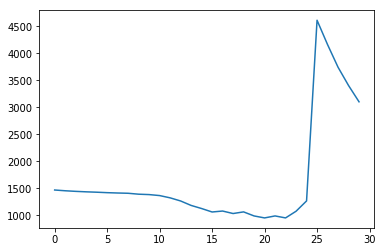

n_correct: 1060 n_total: 2000
train accuracy: 0.53
n_correct: 46 n_total: 100
test accuracy: 0.46


In [16]:
main()